# Implementation of Word2vec

:label:`chapter_word2vec_gluon`



This section is a practice exercise for the two previous sections. We use the
skip-gram model from
:numref:`chapter_word2vec`
and
negative sampling from
:numref:`chapter_approx_train`
as examples to introduce the implementation of word embedding model training on
a corpus. We will also introduce some implementation tricks, such as subsampling
and mask variables.

First, import the packages and modules required for the experiment.

In [1]:
import sys
sys.path.insert(0, '..')

import collections
import d2l
import math
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import random
import time
import zipfile

## Pre-process the Data Set

### Load and Tokenize

Penn Tree Bank (PTB) is a small commonly-used corpus[1]. It takes samples from Wall Street Journal articles and includes training sets, validation sets, and test sets. We will train the word embedding model on the PTB training set. Each line of the data set acts as a sentence. All the words in a sentence are separated by spaces. In this task, each word is a token.

In [2]:
with zipfile.ZipFile('../data/ptb.zip', 'r') as f:
    raw_text = f.read('ptb/ptb.train.txt').decode("utf-8").lower()
sentences = [line.split() for line in raw_text.split('\n')]
'# sentences: %d' % len(sentences)

'# sentences: 42069'

### Build the Vocabulary

Next we build a vocabulary with words appeared not greater than 5 times mapped into a "&lt;unk&gt;" token.

In [3]:
def expand(sentences):
    """Expand a list of token lists into a list of tokens"""
    return [tk for line in sentences for tk in line]

vocab = d2l.Vocab(expand(sentences), min_freq=10)
'vocab size: %d' % len(vocab)

'vocab size: 6719'

### Subsampling

In text data, there are generally some words that appear at high frequencies, such "the", "a", and "in" in English. Generally speaking, in a context window, it is better to train the word embedding model when a word (such as "chip") and a lower-frequency word (such as "microprocessor") appear at the same time, rather than when a word appears with a higher-frequency word (such as "the"). Therefore, when training the word embedding model, we can perform subsampling[2] on the words. Specifically, each indexed word $w_i$ in the data set will drop out at a certain probability. The dropout probability is given as:

$$ \mathbb{P}(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

Here, $f(w_i)$ is the ratio of the instances of word $w_i$ to the total number of words in the data set, and the constant $t$ is a hyper-parameter (set to $10^{-4}$ in this experiment). As we can see, it is only possible to drop out the word $w_i$ in subsampling when $f(w_i) > t$. The higher the word's frequency, the higher its dropout probability.

In [4]:
# Map low frequency words into <unk>
sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
             for line in sentences]
# Count the frequency for each word
tokens = expand(sentences)
counter = collections.Counter(tokens)

def discard(token):
    p = 1 - math.sqrt(1e-4 / counter[token] * len(tokens))
    return random.uniform(0, 1) < p

subsampled = [[tk for tk in line if not discard(tk)] for line in sentences]

Compare the sequence lengths before and after sampling, we can see subsampling significantly reduced the sequence length.

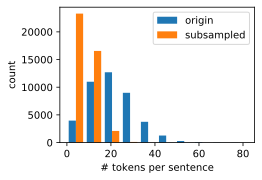

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]] )
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

For individual tokens, the sampling rate of the high-frequency word "the" is less than 1/20.

In [6]:
def compare_counts(token):
    return '# of "%s": before=%d, after=%d' % (token, sum(
        [line.count(token) for line in sentences]), sum(
        [line.count(token) for line in subsampled]))

compare_counts('the')

'# of "the": before=50770, after=2219'

But the low-frequency word "join" is completely preserved.

In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

### Map Tokens into Indices

Lastly, we map each token into an index to construct the corpus.

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[], [2132, 406], [5464, 1, 3080, 1595]]

## Read the Data Set

Next we read the corpus with token indicies into data batches for training.

### Extract Central Target Words and Context Words

We use words with a distance from the central target word not exceeding the context window size as the context words of the given center target word. The following definition function extracts all the central target words and their context words. It uniformly and randomly samples an integer to be used as the context window size between integer 1 and the `max_window_size` (maximum context window).

In [9]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a
        # "central target word - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Next, we create an artificial data set containing two sentences of 7 and 3 words, respectively. Assume the maximum context window is 2 and print all the central target words and their context words.

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In the experiment, we set the maximum context window size to 5. The following extracts all the central target words and their context words in the data set.

In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
'# center-context pairs: %d' % len(all_centers)

'# center-context pairs: 352824'

### Negative Sampling

We use negative sampling for approximate training. For a central and context word pair, we randomly sample $K$ noise words ($K=5$ in the experiment). According to the suggestion in the Word2vec paper, the noise word sampling probability $\mathbb{P}(w)$ is the ratio of the word frequency of $w$ to the total word frequency raised to the power of 0.75 [2].

We first define a class to draw a candidate according to the sampling weights. It caches a 10000 size random number bank instead of calling `random.choices` every time.

In [12]:
class RandomGenerator(object):
    """Draw a random int in [0, n] according to n sampling weights"""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

generator = RandomGenerator([2,3,4])
[generator.draw() for _ in range(10)]

[1, 2, 1, 2, 2, 2, 1, 0, 2, 1]

In [13]:
counter = collections.Counter(expand(corpus))
sampling_weights = [counter[i]**0.75 for i in range(len(counter))]

def get_negatives(all_contexts, sampling_weights, K):
    all_negatives = []
    generator = RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, sampling_weights, 5)

### Read into Batches

We extract all central target words `all_centers`, and the context words `all_contexts` and noise words `all_negatives` of each central target word from the data set. We will read them in random mini-batches.

In a mini-batch of data, the $i$-th example includes a central word and its corresponding $n_i$ context words and $m_i$ noise words. Since the context window size of each example may be different, the sum of context words and noise words, $n_i+m_i$, will be different. When constructing a mini-batch, we concatenate the context words and noise words of each example, and add 0s for padding until the length of the concatenations are the same, that is, the length of all concatenations is $\max_i n_i+m_i$(`max_len`). In order to avoid the effect of padding on the loss function calculation, we construct the mask variable `masks`, each element of which corresponds to an element in the concatenation of context and noise words, `contexts_negatives`. When an element in the variable `contexts_negatives` is a padding, the element in the mask variable `masks` at the same position will be 0. Otherwise, it takes the value 1. In order to distinguish between positive and negative examples, we also need to distinguish the context words from the noise words in the `contexts_negatives` variable. Based on the construction of the mask variable, we only need to create a label variable `labels` with the same shape as the `contexts_negatives` variable and set the elements corresponding to context words (positive examples) to 1, and the rest to 0.

Next, we will implement the mini-batch reading function `batchify`. Its mini-batch input `data` is a list whose length is the batch size, each element of which contains central target words `center`, context words `context`, and noise words `negative`. The mini-batch data returned by this function conforms to the format we need, for example, it includes the mask variable.

In [14]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (nd.array(centers).reshape((-1, 1)), nd.array(contexts_negatives),
            nd.array(masks), nd.array(labels))

Construct two simple examples:

In [15]:
x_1 = (1, [2,2], [3,3,3,3])
x_2 = (1, [2,2,2], [3,3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = 
[[1.]
 [1.]]
<NDArray 2x1 @cpu(0)>
contexts_negatives = 
[[2. 2. 3. 3. 3. 3.]
 [2. 2. 2. 3. 3. 0.]]
<NDArray 2x6 @cpu(0)>
masks = 
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]]
<NDArray 2x6 @cpu(0)>
labels = 
[[1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]]
<NDArray 2x6 @cpu(0)>


We use the `batchify` function just defined to specify the mini-batch reading method in the `DataLoader` instance. Then, we print the shape of each variable in the first batch read.

In [16]:
batch_size = 512
dataset = gdata.ArrayDataset(all_centers, all_contexts, all_negatives)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True,
                             batchify_fn=batchify)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)


## The Skip-Gram Model

We will implement the skip-gram model by using embedding layers and mini-batch multiplication. These methods are also often used to implement other natural language processing applications.

### Embedding Layer

The layer in which the obtained word is embedded is called the embedding layer, which can be obtained by creating an `nn.Embedding` instance in Gluon. The weight of the embedding layer is a matrix whose number of rows is the dictionary size (`input_dim`) and whose number of columns is the dimension of each word vector (`output_dim`). We set the dictionary size to 20 and the word vector dimension to 4.

In [17]:
embed = nn.Embedding(input_dim=20, output_dim=4)
embed.initialize()
embed.weight

Parameter embedding0_weight (shape=(20, 4), dtype=float32)

The input of the embedding layer is the index of the word. When we enter the index $i$ of a word, the embedding layer returns the $i$th row of the weight matrix as its word vector. Below we enter an index of shape (2,3) into the embedding layer. Because the dimension of the word vector is 4, we obtain a word vector of shape (2,3,4).

In [18]:
x = nd.array([[1, 2, 3], [4, 5, 6]])
embed(x)


[[[ 0.01438687  0.05011239  0.00628365  0.04861524]
  [-0.01068833  0.01729892  0.02042518 -0.01618656]
  [-0.00873779 -0.02834515  0.05484822 -0.06206018]]

 [[ 0.06491279 -0.03182812 -0.01631819 -0.00312688]
  [ 0.0408415   0.04370362  0.00404529 -0.0028032 ]
  [ 0.00952624 -0.01501013  0.05958354  0.04705103]]]
<NDArray 2x3x4 @cpu(0)>

### Mini-batch Multiplication

We can multiply the matrices in two mini-batches one by one, by the mini-batch multiplication operation `batch_dot`. Suppose the first batch contains $n$ matrices $\boldsymbol{X}_1, \ldots, \boldsymbol{X}_n$ with a shape of $a\times b$, and the second batch contains $n$ matrices $\boldsymbol{Y}_1, \ldots, \boldsymbol{Y}_n$ with a shape of $b\times c$. The output of matrix multiplication on these two batches are $n$ matrices $\boldsymbol{X}_1\boldsymbol{Y}_1, \ldots, \boldsymbol{X}_n\boldsymbol{Y}_n$ with a shape of $a\times c$. Therefore, given two NDArrays of shape ($n$, $a$, $b$) and ($n$, $b$, $c$), the shape of the mini-batch multiplication output is ($n$, $a$, $c$).

In [19]:
X = nd.ones((2, 1, 4))
Y = nd.ones((2, 4, 6))
nd.batch_dot(X, Y).shape

(2, 1, 6)

### Skip-gram Model Forward Calculation

In forward calculation, the input of the skip-gram model contains the central target word index `center` and the concatenated context and noise word index `contexts_and_negatives`. In which, the `center` variable has the shape (batch size, 1), while the `contexts_and_negatives` variable has the shape (batch size, `max_len`). These two variables are first transformed from word indexes to word vectors by the word embedding layer, and then the output of shape (batch size, 1, `max_len`) is obtained by mini-batch multiplication. Each element in the output is the inner product of the central target word vector and the context word vector or noise word vector.

In [20]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = nd.batch_dot(v, u.swapaxes(1, 2))
    return pred

Verify that the output shape should be (batch size, 1, `max_len`).

In [21]:
skip_gram(nd.ones((2,1)), nd.ones((2,4)), embed, embed).shape

(2, 1, 4)

## Training

Before training the word embedding model, we need to define the loss function of the model.

### Binary Cross Entropy Loss Function

According to the definition of the loss function in negative sampling, we can directly use Gluon's binary cross entropy loss function `SigmoidBinaryCrossEntropyLoss`.

In [22]:
loss = gloss.SigmoidBinaryCrossEntropyLoss()

It is worth mentioning that we can use the mask variable to specify the partial predicted value and label that participate in loss function calculation in the mini-batch: when the mask is 1, the predicted value and label of the corresponding position will participate in the calculation of the loss function; When the mask is 0, the predicted value and label of the corresponding position do not participate in the calculation of the loss function. As we mentioned earlier, mask variables can be used to avoid the effect of padding on loss function calculations.

Given two identical examples, different masks lead to different loss values.

In [23]:
pred = nd.array([[.5]*4]*2)
label = nd.array([[1,0,1,0]]*2)
mask = nd.array([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)


[0.724077  0.3620385]
<NDArray 2 @cpu(0)>

We can normalize the loss in each example due to various lengths in each example.

In [24]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]


[0.724077 0.724077]
<NDArray 2 @cpu(0)>

### Initialize Model Parameters

We construct the embedding layers of the central and context words, respectively, and set the hyper-parameter word vector dimension `embed_size` to 100.

In [25]:
embed_size = 50
net = nn.Sequential()
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size),
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

### Training

The training function is defined below. Because of the existence of padding, the calculation of the loss function is slightly different compared to the previous training functions.

In [26]:
def train(net, lr, num_epochs):
    ctx = d2l.try_gpu()
    net.initialize(ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(1, num_epochs+1):
        start, l_sum, n = time.time(), 0.0, 0
        for batch in data_iter:
            center, context_negative, mask, label = [
                data.as_in_context(ctx) for data in batch]
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])

                l = (loss(pred.reshape(label.shape), label, mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.backward()
            trainer.step(batch_size)
            l_sum += l.sum().asscalar()
            n += l.size
        print('epoch %d, loss %.2f, time %.2fs'
              % (epoch, l_sum/n, time.time() - start))

Now, we can train a skip-gram model using negative sampling.

In [27]:
train(net, 0.005, 5)

epoch 1, loss 0.47, time 19.14s


epoch 2, loss 0.41, time 19.25s


epoch 3, loss 0.38, time 19.04s


epoch 4, loss 0.37, time 19.27s


epoch 5, loss 0.36, time 19.04s


## Applying the Word Embedding Model

After training the word embedding model, we can represent similarity in meaning between words based on the cosine similarity of two word vectors. As we can see, when using the trained word embedding model, the words closest in meaning to the word "chip" are mostly related to chips.

In [28]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability.
    cos = nd.dot(W, x) / (nd.sum(W * W, axis=1) * nd.sum(x * x) + 1e-9).sqrt()
    topk = nd.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print('cosine sim=%.3f: %s' % (cos[i].asscalar(), (vocab.idx_to_token[i])))

get_similar_tokens('chip', 3, net[0])

cosine sim=0.707: microprocessor
cosine sim=0.667: intel
cosine sim=0.649: mips


## Summary

* We can use Gluon to train a skip-gram model through negative sampling.
* Subsampling attempts to minimize the impact of high-frequency words on the training of a word embedding model.
* We can pad examples of different lengths to create mini-batches with examples of all the same length and use mask variables to distinguish between padding and non-padding elements, so that only non-padding elements participate in the calculation of the loss function.


## Exercises

* Set `sparse_grad=True` when creating an instance of `nn.Embedding`. Does it accelerate training? Look up MXNet documentation to learn the meaning of this argument.
* We use the `batchify` function to specify the mini-batch reading method in the `DataLoader` instance and print the shape of each variable in the first batch read. How should these shapes be calculated?
* Try to find synonyms for other words.
* Tune the hyper-parameters and observe and analyze the experimental results.
* When the data set is large, we usually sample the context words and the noise words for the central target word in the current mini-batch only when updating the model parameters. In other words, the same central target word may have different context words or noise words in different epochs. What are the benefits of this sort of training? Try to implement this training method.





## Reference

[1] Penn Tree Bank. https://catalog.ldc.upenn.edu/LDC99T42

[2] Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In Advances in neural information processing systems (pp. 3111-3119).

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2387)

![](../img/qr_word2vec-gluon.svg)